## Analysis of 2017-2018 NBA shooting volatility

The takeaways from this analysis aren't exactly groundbreaking, but I've been wanting to play around with NBA stats for a while, and metrics that give a strong sense of not just efficiency, but also consistency, are always worth examining and aren't always talked about. So I scraped the 2017-2018 individual game box scores to calculate player-level volatility for true shooting, a common advanced shooting metric that takes into account more than just FGM/FGA and is calculated as follows:

points scored / (2 * (FGA + 0.44 * FTA)) * 100

In [3]:
from bs4 import BeautifulSoup
import os
import pandas as pd
import urllib
import numpy as np
import matplotlib.pyplot as plt
import time

I'm scraping the player-level box scores from Basketball Reference. Unfortunately, they're paginated, and there's no file export option, so the below code adds 100 to the "offset" defined in the url to grab the next page of data.

In [4]:
log_link = 'https://www.basketball-reference.com/play-index/pgl_finder.cgi?request=1&player_id=&match=game&year_min=2018&year_max=2018&age_min=0&age_max=99&team_id=&opp_id=&season_start=1&season_end=-1&is_playoffs=N&draft_year=&round_id=&game_num_type=&game_num_min=&game_num_max=&game_month=&game_day=&game_location=&game_result=&is_starter=&is_active=&is_hof=&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&c1stat=&c1comp=&c1val=&c1val_orig=&c2stat=&c2comp=&c2val=&c2val_orig=&c3stat=&c3comp=&c3val=&c3val_orig=&c4stat=&c4comp=&c4val=&c4val_orig=&is_dbl_dbl=&is_trp_dbl=&order_by=pts&order_by_asc=&offset='

In [5]:
### create a list of lists to append scraped data to -- this was just copy/pasted
### from the above url, though I had to add in a couple that were missing a label
log_data = [["Player","Age","Pos","Date","Tm","Home_Away","Opp","Result","GS",
            "MP","FG","FGA","FG%","2P","2PA","2P%","3P","3PA","3P%",
            "FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS","GmSc"]]

In [ ]:
offset = 0
for i in range(0, 40000):
    try:
        html = urllib.request.urlopen(log_link + str(offset))
        soup = BeautifulSoup(html, "html5lib")
        log_table = soup.find('table', {'id': 'stats'}).find('tbody')
        
        for tr in soup.findAll('tr')[1:]:
            
            row_data =[]
            for td in tr.findAll('td'):
                row_data.append(td.text)
                
            if len(row_data) > 0 :
                
                log_data.append(row_data)
        
        offset += 100
#         print("new offset " + str(offset))
        
        time.sleep(1)
        
    except Exception as e:
        #### exception should be: 'NoneType' object has no attribute 'find.'
        ### Otherwise, there's an issue
        print(e)
        break

In [ ]:
df = pd.DataFrame(log_data[1:], columns = log_data[0])

In [ ]:
### write to csv so you don't have to scrape the data each time.
df.to_csv('2017-2018_nba_player_box_scores.csv', index = False)

In [6]:
df = pd.read_csv('2017-2018_nba_player_box_scores.csv')

In [8]:
#### columns are currently strings, need to convert many of them to ints
cols_to_convert = df.columns[8:]

for i in cols_to_convert:
    df[i] = pd.to_numeric(df[i]).astype(float)

In [9]:
### calculate points per 36m and TS % for each game
df['pts_per_36'] = df.PTS / df.MP * 36
df['TS_pct'] = df.PTS / (2 * (df.FGA + 0.44 * df.FTA)) * 100

In [10]:
#### calculate the overall league TS % to reference later
league_ts = df.PTS.sum() / (2 * (df.FGA.sum() + 0.44 * df.FTA.sum())) * 100

In [11]:
### to reduce noise, limit the data to guys who played in at least 50 games
### and averaged at least 10 points per 36 minutes
games_played = df[['Player', 'MP']].groupby('Player').count()
games_played = games_played[games_played.MP >=50]

avg_pts = df[['Player', 'pts_per_36']].groupby('Player').mean()
avg_pts = avg_pts[avg_pts.pts_per_36 >=10]

qual_players = avg_pts.merge(games_played, how='inner', left_index = True, right_index = True)
qual_players = qual_players.reset_index()
qual_players = qual_players[['Player']]

In [12]:
### narrow the game log data to only qualifying players
df_qual = df.merge(qual_players, how = 'inner', on = 'Player')

In [13]:
### calculate the standard deviation of each of the TS pct.
df_qual_std = df_qual[['Player', 'TS_pct']].groupby('Player').std()
df_qual_std = df_qual_std.rename(columns = {'TS_pct': 'TS_std'})

In [14]:
### we also need to calculate averages, but we can't average an average (which is what daily
### TS and pts per 36 are, so we have to go back to the game-level data (df_qual)
df_qual_avg = df_qual[['Player', 'MP', 'PTS', 'FGA', 'FTA']].groupby('Player').sum()
df_qual_avg['pts_per_36_avg'] = df_qual_avg.PTS / df_qual_avg.MP * 36
df_qual_avg['TS_avg'] = (df_qual_avg.PTS / (2 * (df_qual_avg.FGA + 0.44 * df_qual_avg.FTA)) * 100)

df_mp_fga_avg = df_qual[['Player', 'MP', 'FGA']].groupby('Player').mean()
df_mp_fga_avg = df_mp_fga_avg.rename(columns={'MP': 'mp_avg',
                                     'FGA': 'fga_avg'})

df_qual_avg = df_qual_avg.merge(df_mp_fga_avg, how = 'left', left_index= True, right_index=True)

df_qual_avg = df_qual_avg[['mp_avg', 'fga_avg', 'pts_per_36_avg', 'TS_avg']]

In [15]:
### join the average and standard deviation dfs into a final df to analyze
df_qual_adv = df_qual_avg.merge(df_qual_std, how = 'left', left_index = True, right_index = True)

The standard deviations between players, while interesting, aren't the best best metric for variance since each player's distribution has different mean values. Therefore, let's calculate the coefficient of variation for each player's true shooting rate.

In [16]:
df_qual_adv['TS_coef_var'] = (df_qual_adv['TS_std'] /df_qual_adv['TS_avg'])

**Surprise! LeBron and Giannis are really good at basketball!** When we sort to see the players with the lowest coefficient of variance scores, it's amazing, albeit not exactly stunning, to see that the top four players in the MVP race are also the most consistent in the league when it comes to shooting efficiency.

In [17]:
df_qual_adv[['pts_per_36_avg','TS_avg', 'TS_coef_var']].sort_values(by='TS_coef_var').head(10)

,pts_per_36_avg,TS_avg,TS_coef_var
Player,,,
LeBron James,26.754168,62.237089,0.171494
Giannis Antetokounmpo,26.487472,60.348264,0.171914
James Harden,31.140454,61.673982,0.179803
Anthony Davis,27.791484,61.393959,0.180632
Joel Embiid,27.192891,57.273996,0.188045
Blake Griffin,22.707974,54.416404,0.188273
Kevin Durant,27.523356,64.378371,0.192681
Clint Capela,18.217551,64.965729,0.194486
Damian Lillard,26.176565,59.347570,0.194888


To add a bit more context, let's see where some of these very consistent scoreres sit within the context of the entire league. The below plot, which compares true shooting pct. (x-axis) to true shooting volatility (y-axis) is a bit noisy, but you can see many of the above names in the lower right quadrant of the below plot, where the scoring efficiency is above the median (vertical red line) and below the median coefficient of variation (horizontal red line) among players who've played at least 50 games and average at least 10 pts. per 36 min.

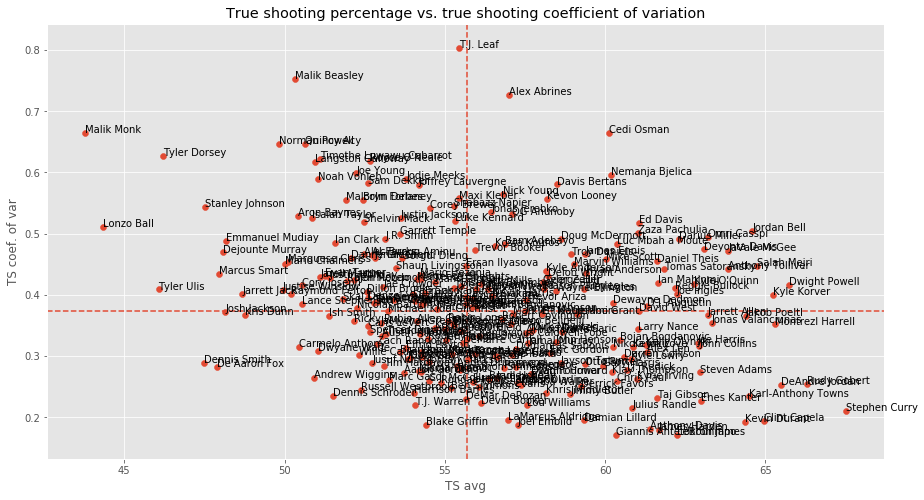

In [18]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,8))
x, y = df_qual_adv['TS_avg'], df_qual_adv['TS_coef_var']
plt.scatter(x, y)
plt.xlabel('TS avg')
plt.ylabel('TS coef. of var')
plt.title('True shooting percentage vs. true shooting coefficient of variation')
for i, txt in enumerate(df_qual_adv.index):
    ax.annotate(txt, (x.values[i],
                      y.values[i]))
plt.axvline(x.median(), linestyle='dashed')
plt.axhline(y.median(), linestyle = 'dashed')
plt.show()

The above plot provides good context and has some interesting outliers, but also invites some pointless comparisons (Would Enes Kanter maintain his Kevin Durant-like effeciency and consistency with Kevin Durant's usage rate?). To make this plot more coherent and make comparisons more useful, let's limit the above plot to higher volume shooters

In [19]:
df_shooters = df_qual_adv.sort_values(by='fga_avg', ascending = False).head(50)

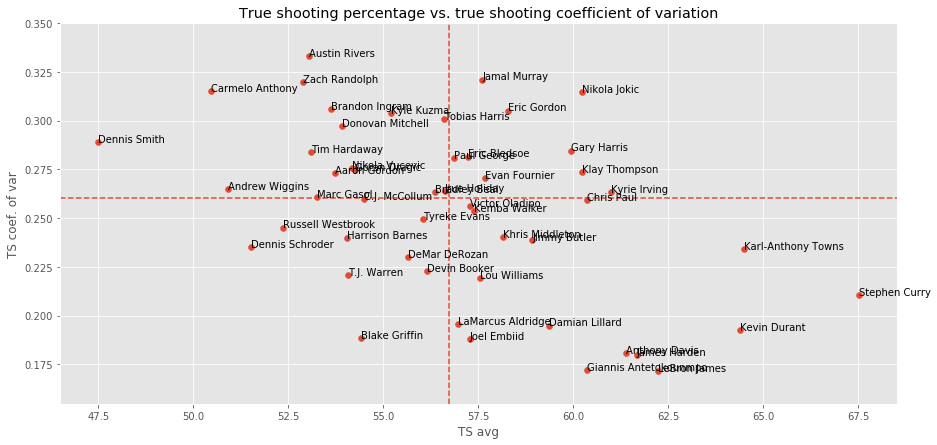

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
x_sh, y_sh = df_shooters['TS_avg'], df_shooters['TS_coef_var']
plt.scatter(x_sh, y_sh)
plt.xlabel('TS avg')
plt.ylabel('TS coef. of var')
plt.title('True shooting percentage vs. true shooting coefficient of variation')
for i, txt in enumerate(df_shooters.index):
    ax.annotate(txt, (x_sh.values[i],
                      y_sh.values[i]))
plt.axvline(x_sh.median(), linestyle='dashed')
plt.axhline(y_sh.median(), linestyle = 'dashed')
plt.show()

In [21]:
### Let's look at the least consistent players among higher-volume shooters.
df_shooters[['fga_avg', 'pts_per_36_avg','TS_avg', 'TS_coef_var']].sort_values(by='TS_coef_var').tail(10)

,fga_avg,pts_per_36_avg,TS_avg,TS_coef_var
Player,,,,
Donovan Mitchell,17.232877,21.835583,53.908454,0.297197
Tobias Harris,15.216216,19.962843,56.589620,0.300655
Kyle Kuzma,13.369863,18.603707,55.210848,0.303960
Eric Gordon,14.151515,21.033317,58.294149,0.305103
Brandon Ingram,12.898305,17.271992,53.610973,0.306043
Nikola Jokic,12.985507,20.079746,60.234479,0.314773
Carmelo Anthony,15.082192,18.229787,50.452803,0.314933
Zach Randolph,12.932203,20.458886,52.896010,0.319681
Jamal Murray,13.026667,19.093242,57.597265,0.321031


Just for fun, let's compare the efficiency and consistency of LeBron to Donovan Mitchell (who is having an incredible rookie season!), but is one of the most volatile shooters among the league's 50 players who take the most shots per game.

In [22]:
lebron = df_qual[df_qual['Player'] == 'LeBron James']['TS_pct']
donovan = df_qual[df_qual['Player'] == 'Donovan Mitchell']['TS_pct']

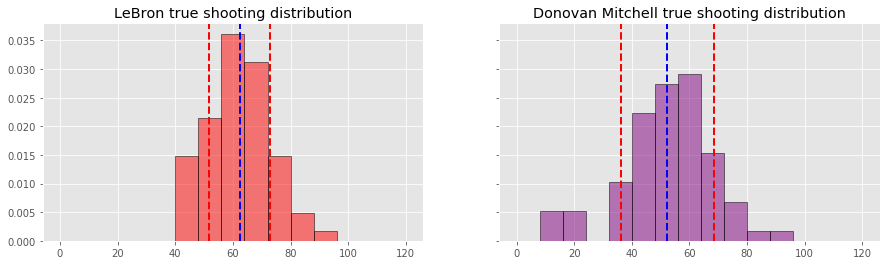

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), sharey= True)
ax1.hist(lebron, range=[0, 120], bins = 15, color = 'red',
         alpha = 0.5, edgecolor = 'black', linewidth = 1, normed = True)
ax1.set_title('LeBron true shooting distribution')
ax1.axvline(lebron.median(), color='b', linestyle='dashed', linewidth=2)
ax1.axvline(lebron.median()-(lebron.std()), color='red', linestyle='dashed', linewidth=2)
ax1.axvline(lebron.median()+(lebron.std()), color='red', linestyle='dashed', linewidth=2)

ax2.hist(donovan, range=[0, 120], bins = 15, color = 'purple',
         alpha = 0.5, edgecolor = 'black', linewidth = 1, normed = True)
ax2.set_title('Donovan Mitchell true shooting distribution')
ax2.axvline(donovan.mean(), color='b', linestyle='dashed', linewidth=2)
ax2.axvline(donovan.mean()-(donovan.std()), color='red', linestyle='dashed', linewidth=2)
ax2.axvline(donovan.mean()+(donovan.std()), color='red', linestyle='dashed', linewidth=2)
plt.show()

Mitchell has had a few incredibly efficient games, but he's also had a fair number with a TS % below 40 percent. LeBron, on the other hand, has not had a single game where his TS% dropped below 40! Also, notice how much closer LeBron's standard deviation markers are to his mean. Let's take a look at the same distributions laid on top of one another.

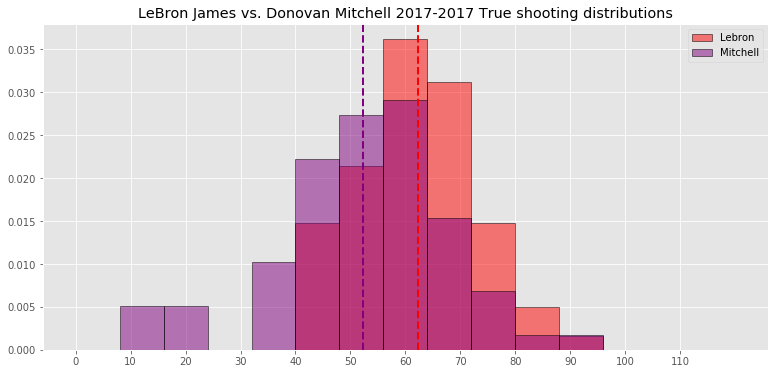

In [24]:
fig, ax = plt.subplots(figsize=(13,6))
plt.hist(lebron, range=[0, 120], bins = 15, color = 'red', label = 'Lebron',
        alpha = 0.5, edgecolor = 'black', linewidth = 1, normed = True)
plt.hist(donovan, range=[0, 120], bins = 15, color = 'purple', label = 'Mitchell',
         alpha = 0.5, edgecolor = 'black', linewidth = 1, normed = True)
plt.axvline(lebron.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(donovan.mean(), color='purple', linestyle='dashed', linewidth=2)
plt.xticks(np.arange(0, 120, 10))
plt.title('LeBron James vs. Donovan Mitchell 2017-2017 True shooting distributions')
plt.legend()
plt.show()

But less variance isn't everything, especially if the positive tail of a player's distribution is as insane as Steph Curry's. Let's take a look at how he compares to LeBron.

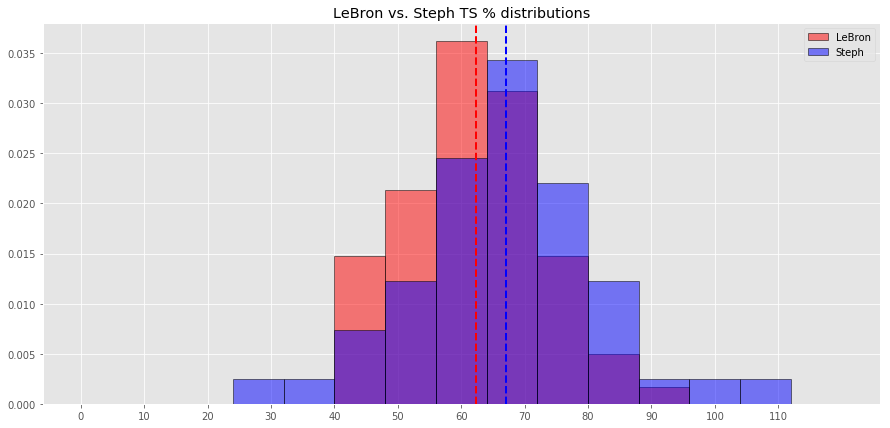

In [25]:
steph = df_qual[df_qual['Player'] == 'Stephen Curry']['TS_pct']
fig, ax = plt.subplots(figsize=(15,7))
plt.hist(lebron, range=[0, 120], bins = 15, color = 'red', label = 'LeBron',
         alpha = 0.5, edgecolor = 'black', linewidth = 1, normed = True)
plt.hist(steph, range=[0, 120], bins = 15, color = 'blue', label = 'Steph',
         alpha = 0.5, edgecolor = 'black', linewidth = 1, normed = True)
plt.axvline(lebron.mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(steph.mean(), color='b', linestyle='dashed', linewidth=2)
plt.xticks(np.arange(0, 120, 10))
plt.title('LeBron vs. Steph TS % distributions')
plt.legend()
plt.show()

From the above plot, we can see that Curry more than makes up for a handful of very inefficient games with a lot of games that even exceed the efficiency of LeBron. In fact, in nearly two-thirds of his games, Curry's TS% is above LeBron's overall average. 

In [26]:
len(steph[steph > lebron.mean()]) / len(steph)

0.6470588235294118

If we were to then zoom out a bit to see how Curry's efficiency compares to the rest of the leage, we can calculate, among all qualifying players, the share of games where a player had a TS% above the league average. The only player ahead of him is Clint Capella, a guy who literally just dunks off of wide-open lob passes from James Harden. The fact that Curry is barely behind him is incredible.

In [27]:
df_above_league_ts = df_qual.set_index('Player').TS_pct.ge(league_ts)\
                .groupby(level=0).value_counts(True).unstack(fill_value=0)
df_above_league_ts.sort_values(by=1, ascending = False).head(10)

TS_pct,False,True
Player,,
Clint Capela,0.188406,0.811594
Stephen Curry,0.196078,0.803922
Kevin Durant,0.245902,0.754098
Montrezl Harrell,0.257143,0.742857
Karl-Anthony Towns,0.259740,0.740260
Rudy Gobert,0.280000,0.720000
Steven Adams,0.281690,0.718310
Enes Kanter,0.281690,0.718310
LeBron James,0.289474,0.710526


Earlier, we noted that LeBron, despite ranking among league leaders in shots per game and usage rate, hasnt had a single game with a TS % below 40. How rare is that? So rare that Kevin Durant is the only player to have achieved that.

In [30]:
df_ts_below_40 = df_qual.set_index('Player').TS_pct.le(39.9999)\
                .groupby(level=0).value_counts(True).unstack(fill_value=0)
df_ts_below_40.sort_values(by=0, ascending = False).head(10)

TS_pct,False,True
Player,,
Kevin Durant,1.000000,0.000000
LeBron James,1.000000,0.000000
Karl-Anthony Towns,0.987013,0.012987
Giannis Antetokounmpo,0.985915,0.014085
Clint Capela,0.985507,0.014493
Rudy Gobert,0.980000,0.020000
Enes Kanter,0.971831,0.028169
James Harden,0.970149,0.029851
Stephen Curry,0.960784,0.039216


And on the opposite end of the spectrum, we can see struggles of Lakers rookie Lonzo Ball, who leads the NBA in the share of his games where his TS % is below 40.

In [31]:
df_ts_below_40.sort_values(by=0, ascending = True).head(10)

TS_pct,False,True
Player,,
Lonzo Ball,0.557692,0.442308
Tyler Ulis,0.575758,0.424242
Aron Baynes,0.581081,0.418919
Ian Clark,0.585714,0.414286
Langston Galloway,0.592593,0.407407
Marcus Smart,0.592593,0.407407
Norman Powell,0.603175,0.396825
Malik Monk,0.614035,0.385965
Alec Burks,0.622951,0.377049
